In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import integrate, interpolate
from scipy import optimize
from torch.autograd import grad
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
from scipy.integrate import solve_ivp, odeint
from scipy.interpolate import interp1d

In [ ]:
def no_GEM(y, t, k1, k2, k4, k5, kd, feedback, kd_blood1=0.0000006, kd_blood2=0.05):
    """
    kd_blood1 = death rate of macrophages - set as constant
    kd_blood2 = death rate of neutrophils - set as constant
    kd = death rate
    feedback = feedback from differentiated (blood) to progenitor (G1/S)
    """

    G1, G2, blood1, blood2 = y
    dydt = [-k1*G1 + 2*k2*G2 - kd*G1 - feedback*(blood1+blood2), k1*G1 - k2*G2 - k4*G2 - k5*G2 - kd*G2, k4*G2-kd_blood1*blood1, k5*G2-kd_blood2*blood2]
    return dydt

In [6]:
# load data

data = pd.read_csv('./blood_fitting_example.csv')



In [16]:
data

,2,4,6,8,10,12,14,16,18,20,...,222,224,226,228,230,232,234,236,238,240
MEP_g1,1.274357,1.274357,1.274357,1.274357,1.274357,1.274357,1.274357,1.274357,1.274357,1.274357,...,1.274357,1.274357,1.274357,1.274357,1.274357,1.274357,1.274357,1.274357,1.274357,1.274357
MEP_s,2.354896,2.354896,2.354896,2.354896,2.354896,2.354896,2.354896,2.354896,2.354896,2.354896,...,2.354896,2.354896,2.354896,2.354896,2.354896,2.354896,2.354896,2.354896,2.354896,2.354896
MEP_g2m,0.001531,0.001531,0.001531,0.001531,0.001531,0.001531,0.001531,0.001531,0.001531,0.001531,...,0.001531,0.001531,0.001531,0.001531,0.001531,0.001531,0.001531,0.001531,0.001531,0.001531
CMP_g1,3.753676,3.753676,3.753676,3.753676,3.753676,3.753676,3.753676,3.753676,3.753676,3.753676,...,3.753676,3.753676,3.753676,3.753676,3.753676,3.753676,3.753676,3.753676,3.753676,3.753676
CMP_s,0.812144,0.812144,0.812144,0.812144,0.812144,0.812144,0.812144,0.812144,0.812144,0.812144,...,0.812144,0.812144,0.812144,0.812144,0.812144,0.812144,0.812144,0.812144,0.812144,0.812144
CMP_g2m,5.767375,5.767375,5.767375,5.767375,5.767375,5.767375,5.767375,5.767375,5.767375,5.767375,...,5.767375,5.767375,5.767375,5.767375,5.767375,5.767375,5.767375,5.767375,5.767375,5.767375
CLP_g1,21.382339,21.382339,21.382339,21.382339,21.382339,21.382339,21.382339,21.382339,21.382339,21.382339,...,21.382339,21.382339,21.382339,21.382339,21.382339,21.382339,21.382339,21.382339,21.382339,21.382339
CLP_s,4.856186,4.856186,4.856186,4.856186,4.856186,4.856186,4.856186,4.856186,4.856186,4.856186,...,4.856186,4.856186,4.856186,4.856186,4.856186,4.856186,4.856186,4.856186,4.856186,4.856186
CLP_g2m,17.135511,17.135511,17.135511,17.135511,17.135511,17.135511,17.135511,17.135511,17.135511,17.135511,...,17.135511,17.135511,17.135511,17.135511,17.135511,17.135511,17.135511,17.135511,17.135511,17.135511
Platelets,22.422068,22.422068,22.422068,22.422068,22.422068,22.422068,22.422068,22.422068,22.422068,22.422068,...,22.422068,22.422068,22.422068,22.422068,22.422068,22.422068,22.422068,22.422068,22.422068,22.422068


In [24]:
# D = data.iloc[0,:-1]
G1 = data.loc['CMP_g1'] + data.loc['CMP_s']
G2 = data.loc['CMP_g2m']
blood1 = data.loc['Neutrophils']
blood2 = data.loc['Macrophages']

# D_ar = D.to_numpy()
G1_ar = G1.to_numpy()
G2_ar = G2.to_numpy()
blood1_ar = blood1.to_numpy()
blood2_ar = blood2.to_numpy()

In [22]:
print(G1_ar)

[4.56582041 4.56582041 4.56582041 4.56582041 4.56582041 4.56582041
 4.56582041 4.56582041 4.56582041 4.56582041 4.56582041 4.56582041
 4.56582041 4.56582041 4.56582041 4.56582041 4.56582041 4.56582041
 4.56582041 4.56582041 4.56582041 4.56582041 4.56582041 4.56582041
 4.56582041 4.56582041 4.56582041 4.56582041 4.56582041 4.56582041
 4.56582041 4.56582041 4.56582041 4.56582041 4.56582041 4.56582041
 4.56582041 4.56582041 4.56582041 4.56582041 4.56582041 4.56582041
 4.56582041 4.56582041 4.56582041 4.56582041 4.56582041 4.56582041
 4.56582041 4.56582041 4.56582041 4.56582041 4.56582041 4.56582041
 4.56582041 4.56582041 4.56582041 4.56582041 4.56582041 4.56582041
 4.56582041 4.56582041 4.56582041 4.56582041 4.56582041 4.56582041
 4.56582041 4.56582041 4.56582041 4.56582041 4.56582041 4.56582041
 4.56582041 4.56582041 4.56582041 4.56582041 4.56582041 4.56582041
 4.56582041 4.56582041 4.56582041 4.56582041 4.56582041 4.56582041
 4.56582041 4.56582041 4.56582041 4.56582041 4.56582041 4.5658

In [32]:
print(G2_ar)

[5.76737466 5.76737466 5.76737466 5.76737466 5.76737466 5.76737466
 5.76737466 5.76737466 5.76737466 5.76737466 5.76737466 5.76737466
 5.76737466 5.76737466 5.76737466 5.76737466 5.76737466 5.76737466
 5.76737466 5.76737466 5.76737466 5.76737466 5.76737466 5.76737466
 5.76737466 5.76737466 5.76737466 5.76737466 5.76737466 5.76737466
 5.76737466 5.76737466 5.76737466 5.76737466 5.76737466 5.76737466
 5.76737466 5.76737466 5.76737466 5.76737466 5.76737466 5.76737466
 5.76737466 5.76737466 5.76737466 5.76737466 5.76737466 5.76737466
 5.76737466 5.76737466 5.76737466 5.76737466 5.76737466 5.76737466
 5.76737466 5.76737466 5.76737466 5.76737466 5.76737466 5.76737466
 5.76737466 5.76737466 5.76737466 5.76737466 5.76737466 5.76737466
 5.76737466 5.76737466 5.76737466 5.76737466 5.76737466 5.76737466
 5.76737466 5.76737466 5.76737466 5.76737466 5.76737466 5.76737466
 5.76737466 5.76737466 5.76737466 5.76737466 5.76737466 5.76737466
 5.76737466 5.76737466 5.76737466 5.76737466 5.76737466 5.7673

In [33]:
print(blood1_ar)

[2.55155425 2.55155425 2.55155425 2.55155425 2.55155425 2.55155425
 2.55155425 2.55155425 2.55155425 2.55155425 2.55155425 2.55155425
 2.55155425 2.55155425 2.55155425 2.55155425 2.55155425 2.55155425
 2.55155425 2.55155425 2.55155425 2.55155425 2.55155425 2.55155425
 2.55155425 2.55155425 2.55155425 2.55155425 2.55155425 2.55155425
 2.55155425 2.55155425 2.55155425 2.55155425 2.55155425 2.55155425
 2.55155425 2.55155425 2.55155425 2.55155425 2.55155425 2.55155425
 2.55155425 2.55155425 2.55155425 2.55155425 2.55155425 2.55155425
 2.55155425 2.55155425 2.55155425 2.55155425 2.55155425 2.55155425
 2.55155425 2.55155425 2.55155425 2.55155425 2.55155425 2.55155425
 2.55155425 2.55155425 2.55155425 2.55155425 2.55155425 2.55155425
 2.55155425 2.55155425 2.55155425 2.55155425 2.55155425 2.55155425
 2.55155425 2.55155425 2.55155425 2.55155425 2.55155425 2.55155425
 2.55155425 2.55155425 2.55155425 2.55155425 2.55155425 2.55155425
 2.55155425 2.55155425 2.55155425 2.55155425 2.55155425 2.5515

In [34]:
print(blood2_ar)

[5.89947861 5.89947861 5.89947861 5.89947861 5.89947861 5.89947861
 5.89947861 5.89947861 5.89947861 5.89947861 5.89947861 5.89947861
 5.89947861 5.89947861 5.89947861 5.89947861 5.89947861 5.89947861
 5.89947861 5.89947861 5.89947861 5.89947861 5.89947861 5.89947861
 5.89947861 5.89947861 5.89947861 5.89947861 5.89947861 5.89947861
 5.89947861 5.89947861 5.89947861 5.89947861 5.89947861 5.89947861
 5.89947861 5.89947861 5.89947861 5.89947861 5.89947861 5.89947861
 5.89947861 5.89947861 5.89947861 5.89947861 5.89947861 5.89947861
 5.89947861 5.89947861 5.89947861 5.89947861 5.89947861 5.89947861
 5.89947861 5.89947861 5.89947861 5.89947861 5.89947861 5.89947861
 5.89947861 5.89947861 5.89947861 5.89947861 5.89947861 5.89947861
 5.89947861 5.89947861 5.89947861 5.89947861 5.89947861 5.89947861
 5.89947861 5.89947861 5.89947861 5.89947861 5.89947861 5.89947861
 5.89947861 5.89947861 5.89947861 5.89947861 5.89947861 5.89947861
 5.89947861 5.89947861 5.89947861 5.89947861 5.89947861 5.8994

In [26]:
# scaling the data

max_G1_data = np.max(G1_ar)
max_G2_data = np.max(G2_ar)
max_blood1_data = np.max(blood1_ar)
max_blood2_data = np.max(blood2_ar)

max_data = np.max([max_G1_data,max_G2_data,max_blood1_data,max_blood2_data])

In [27]:
print(max_G1_data)

4.565820408309124


In [28]:
print(max_G2_data)

5.76737466009833


In [30]:
print(max_blood1_data)

2.55155425195696


In [31]:
print(max_blood2_data)

5.89947860746825


In [15]:
t = np.linspace(2,39,38)

print(t)

[ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39.]


In [16]:
# PINN for a system of ODE


class PINN_sys(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PINN_sys, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size), nn.Tanh(),
            nn.Linear(hidden_size, hidden_size), nn.Tanh(),
            nn.Linear(hidden_size, hidden_size), nn.Tanh(),
            nn.Linear(hidden_size, hidden_size), nn.Tanh(),
            nn.Linear(hidden_size, output_size), nn.Tanh()
        )
        self.params = nn.Parameter(torch.rand(4))  # Learnable parameters

    def forward(self, x):
        return self.net(x)

# Training function
def train_pinn_sys(model, 
                   t_train, 
                   G1_data,
                   G2_data,
                   P_data,
                   D_data,
                   zero_init,
                   num_epochs, 
                   learning_rate
                   ):
    
    # Define the loss function (MSE for the PINN)
    criterion = nn.MSELoss()

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Define the learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=50, factor=0.5, verbose=True)
    
    # write the loss and params to a list
    epoch_list = []
    loss_list = []
    k1_list = []
    k2_list = []
    k3_list = []
    kd_list = []

    # Training loop
    for epoch in range(num_epochs):
        # Convert to PyTorch tensors
        t_train = torch.FloatTensor(t_train.reshape(-1, 1))
        G1_tensor = torch.FloatTensor(G1_data.reshape(-1, 1))
        G2_tensor = torch.FloatTensor(G2_data.reshape(-1, 1))
        P_tensor = torch.FloatTensor(P_data.reshape(-1, 1))
        D_tensor = torch.FloatTensor(D_data.reshape(-1, 1))
        zero_init = torch.FloatTensor(zero_init.reshape(-1, 1))
        
        t_train.requires_grad_()

        # Forward pass
        NN = model(t_train)
        G1, G2, P, D = torch.split(NN, 1, dim=1)
        
        G1_ones = torch.ones_like(G1)
        G2_ones = torch.ones_like(G2)
        P_ones = torch.ones_like(P)
        D_ones = torch.ones_like(D)

        # Compute the gradients of the variables
        G1_t = grad(G1, t_train, G1_ones, create_graph=True)[0]
        G2_t = grad(G2, t_train, G2_ones, create_graph=True)[0]
        P_t = grad(P, t_train, P_ones, create_graph=True)[0]
        D_t = grad(D, t_train, D_ones, create_graph=True)[0]
        
        # ensure the model parameters are positive
        param_reg = torch.abs(model.params)
        k1 = param_reg[0]
        k2 = param_reg[1]
        k3 = param_reg[2]
        kd = param_reg[3]
        
        # residual loss
        l1 = criterion(G1_t, -k1*G1 + 2*k2*G2 - kd*G1)
        l2 = criterion(G2_t, k1*G1 - 2*k2*G2 - k3*G2 - kd*G2)
        l3 = criterion(P_t, k3*G2)
        l4 = criterion(D_t, kd*(G1+G2))
        
        # data loss
        sum_loss1 = criterion(G1, G1_tensor)
        sum_loss2 = criterion(G2, G2_tensor)
        sum_loss3 = criterion(P, P_tensor)
        sum_loss4 = criterion(D, D_tensor)
        
        # initial conditions loss
        G1_init_loss = criterion(G1[0], zero_init[0])
        G2_init_loss = criterion(G2[0], zero_init[1])
        P_init_loss = criterion(P[0], zero_init[2])
        D_init_loss = criterion(D[0], zero_init[3])
        
       
        # residual loss + data loss + initial conditions loss 
        total_loss = (l1 + l2 + l3 + l4 + \
                      sum_loss1 + sum_loss2 + sum_loss3 + sum_loss4 +  \
                      G1_init_loss + G2_init_loss + P_init_loss + D_init_loss)       

        # Backward pass and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # Update the learning rate based on the validation loss
        scheduler.step(total_loss)
        
        # Print progress
        if (epoch + 1) % 200 == 0:
            loss_item = round(total_loss.item(), 4)
            param_item = param_reg.data.numpy()
            epoch_list.append(epoch+1)
            loss_list.append(loss_item)
            k1_list.append(param_item[0])
            k2_list.append(param_item[1])
            k3_list.append(param_item[2])
            kd_list.append(param_item[3])
            print(f'Epoch [{epoch+1}/{num_epochs}]', 
                  f'Loss: {total_loss.item():.2e}', 
                  f'params: {param_reg.data.numpy()}')
            
        # save list containing loss and params to csv files
        loss_param_df = pd.DataFrame(data={"Num Epoch": epoch_list,
                                           "loss": loss_list,
                                           "k1": k1_list,
                                           "k2": k2_list,
                                           "k3": k3_list,
                                           "kd": kd_list
                                           })
        loss_param_df.to_csv("./loss_param_1.csv", sep=',',index=False)

    print('Training completed.')

t_train = t
G1_data = G1_ar / max_data
G2_data = G2_ar / max_data
P_data = P_ar / max_data
D_data = D_ar / max_data

# Set initial conditions for all variables
zero_init = np.array([G1_data[0],G2_data[0],P_data[0],D_data[0]])

# Create and train the PINN model
input_size = 1
hidden_size = 32
output_size = 4
num_epochs =  5000
learning_rate = 1e-3

model = PINN_sys(input_size, hidden_size, output_size)
train_pinn_sys(model,
               t_train,
               G1_data,
               G2_data,
               P_data,
               D_data,
               zero_init,
               num_epochs,
               learning_rate
               )

# Test the trained model
t_test = t
t_test = torch.FloatTensor(t_test.reshape(-1, 1))
no_GEM_pred = model(t_test).detach().numpy()

G1_pred = no_GEM_pred[:, 0] * max_data
G2_pred = no_GEM_pred[:, 1] * max_data
P_pred = no_GEM_pred[:, 2] * max_data
D_pred = no_GEM_pred[:, 3] * max_data


Epoch [200/5000] Loss: 7.96e-02 params: [5.8445197e-01 1.0989130e+00 1.8202700e-06 2.7106926e-01]
Epoch [400/5000] Loss: 1.51e-02 params: [4.2307496e-01 1.2181555e+00 1.2150701e-04 9.7430199e-02]
Epoch [600/5000] Loss: 3.60e-03 params: [3.3047301e-01 1.2685844e+00 3.4030272e-05 2.2288479e-02]
Epoch [800/5000] Loss: 2.00e-03 params: [2.7399307e-01 1.2927351e+00 2.7293934e-05 2.3745297e-04]
Epoch [1000/5000] Loss: 5.30e-03 params: [2.3812696e-01 1.3058236e+00 1.7714956e-05 5.1472812e-06]
Epoch [1200/5000] Loss: 2.16e-03 params: [2.1616362e-01 1.3130952e+00 2.6007543e-05 5.8823734e-06]
Epoch 01217: reducing learning rate of group 0 to 5.0000e-04.
Epoch [1400/5000] Loss: 1.47e-03 params: [2.0866302e-01 1.3155487e+00 5.9368026e-06 2.1555261e-06]
Epoch [1600/5000] Loss: 1.44e-03 params: [2.0349285e-01 1.3172818e+00 6.6719103e-06 1.5145930e-06]
Epoch [1800/5000] Loss: 1.42e-03 params: [1.9976142e-01 1.3185983e+00 6.5390213e-07 1.2074247e-06]
Epoch [2000/5000] Loss: 1.40e-03 params: [1.9722418

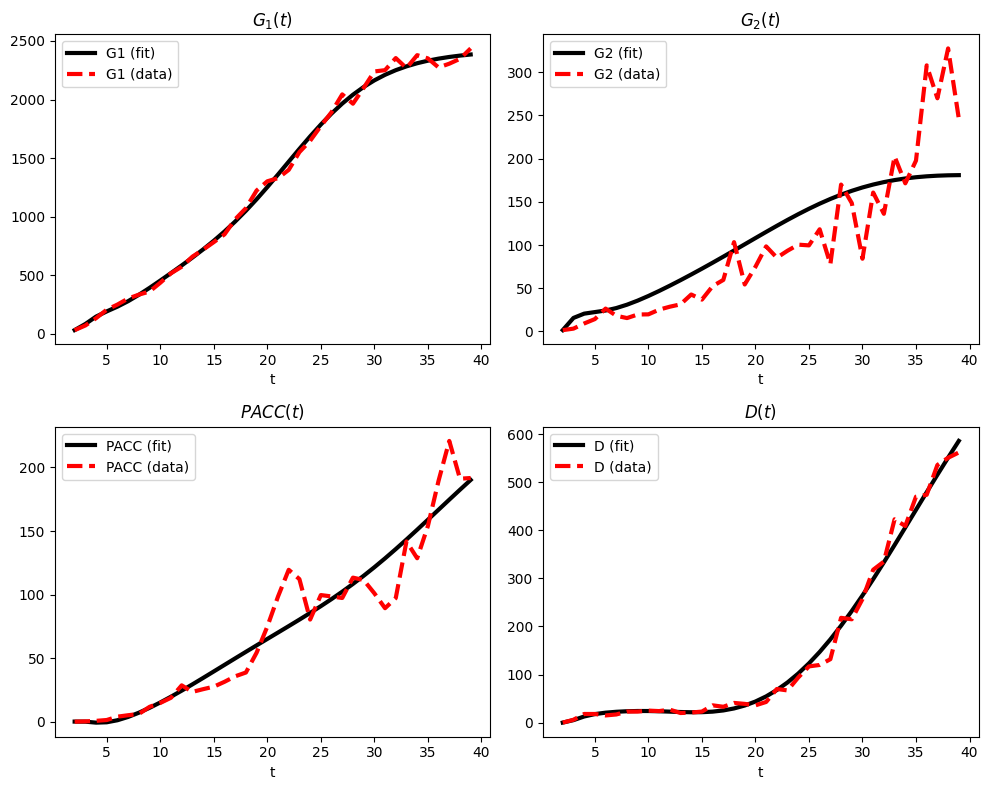

In [17]:
fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

ax0.set_title(r'$G_1(t)$',fontsize = 12)
ax0.plot(t, G1_pred, 'k-', label='G1 (fit)',linewidth=3.0)
ax0.plot(t, G1_ar, 'r--', label='G1 (data)',linewidth=3.0)
ax0.set_xlabel('t',fontsize = 10)
ax0.legend()

ax1.set_title(r'$G_2(t)$',fontsize = 12)
ax1.plot(t, G2_pred, 'k-', label='G2 (fit)',linewidth=3.0)
ax1.plot(t, G2_ar, 'r--', label='G2 (data)',linewidth=3.0)
ax1.set_xlabel('t',fontsize = 10)
ax1.legend()

ax2.set_title(r'$PACC(t)$',fontsize = 12)
ax2.plot(t, P_pred, 'k-', label='PACC (fit)',linewidth=3.0)
ax2.plot(t, P, 'r--', label='PACC (data)',linewidth=3.0)
ax2.set_xlabel('t',fontsize = 10)
ax2.legend()

ax3.set_title(r'$D(t)$',fontsize = 12)
ax3.plot(t, D_pred, 'k-', label='D (fit) ',linewidth=3.0)
ax3.plot(t, D_ar, 'r--', label=r'D (data)',linewidth=3.0)
ax3.set_xlabel('t',fontsize = 10)
ax3.legend()

fig.tight_layout()

plt.show()

In [18]:
# PINN params
loss_param_df = pd.read_csv('loss_param_1.csv')

loss_param_df.tail()

,Num Epoch,loss,k1,k2,k3,kd
20,4200,0.0013,0.193694,1.323573,0.000031,7.218547e-07
21,4400,0.0013,0.193719,1.323827,0.000007,6.187013e-07
22,4600,0.0013,0.193747,1.324109,0.000038,6.438906e-07
23,4800,0.0013,0.193780,1.324425,0.000038,9.097106e-07
24,5000,0.0013,0.193819,1.324772,0.000007,1.119511e-06


In [19]:
epoch = loss_param_df['Num Epoch']
loss = loss_param_df['loss']

k1 = loss_param_df['k1']
k2 = loss_param_df['k2']
k3 = loss_param_df['k3']
kd = loss_param_df['kd']



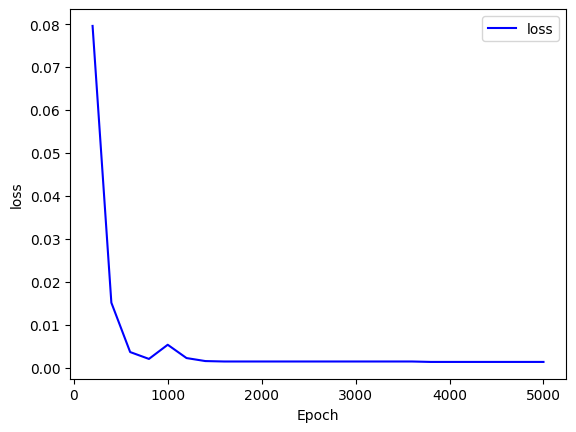

In [20]:

plt.plot(epoch, loss, color='b', label='loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [21]:
# param

k1_param = k1[len(k1)-1]
k2_param = k2[len(k2)-1]
k3_param = k3[len(k3)-1]
kd_param = kd[len(kd)-1]


In [22]:
print('k1='+str(k1_param))
print('k2='+str(k2_param))
print('k3='+str(k3_param))
print('kd='+str(kd_param))



k1=0.19381903
k2=1.3247724
k3=6.683482e-06
kd=1.1195108e-06
